In [1]:
import torch
torch.cuda.empty_cache()
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,\
    TrainingArguments, Trainer, pipeline, DataCollatorWithPadding, set_seed
import evaluate
import numpy as np
import pandas as pd
import torch.nn as nn
import math
import time
from tqdm import tqdm

c:\Users\hamza\anaconda3\envs\csci5541\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seed(42)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
snli = load_dataset("snli")
snli

Found cached dataset snli (C:/Users/hamza/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
100%|██████████| 3/3 [00:00<00:00, 428.16it/s]


DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [4]:
# per chatGPT's suggestion, let's concatenate premise + hypothesis into a "text" column.
train_text = np.char.add(np.char.add(snli['train']['premise'], ' '), snli['train']['hypothesis'])
test_text = np.char.add(np.char.add(snli['test']['premise'], ' '), snli['test']['hypothesis'])
valid_text = np.char.add(np.char.add(snli['validation']['premise'], ' '), snli['validation']['hypothesis'])

# let's do a sanity check to make sure concatenation was done correctly
print(f'--train_text[0]--: {train_text[0]}')
print(f'--original + hypothesis--: {snli["train"]["premise"][0]+snli["train"]["hypothesis"][0]}\n')

print(f'--test_text[0]--: {test_text[0]}')
print(f'--original + hypothesis--: {snli["test"]["premise"][0]+snli["test"]["hypothesis"][0]}\n')

print(f'--valid_text[0]--: {valid_text[0]}')
print(f'--original + hypothesis--: {snli["validation"]["premise"][0]+snli["validation"]["hypothesis"][0]}')

snli["train"] = snli["train"].remove_columns(["premise", "hypothesis"])
snli["train"] = snli["train"].add_column("text", train_text)

snli["test"] = snli["test"].remove_columns(["premise", "hypothesis"])
snli["test"] = snli["test"].add_column("text", test_text)

snli["validation"] = snli["validation"].remove_columns(["premise", "hypothesis"])
snli["validation"] = snli["validation"].add_column("text", valid_text)

snli

--train_text[0]--: A person on a horse jumps over a broken down airplane. A person is training his horse for a competition.
--original + hypothesis--: A person on a horse jumps over a broken down airplane.A person is training his horse for a competition.

--test_text[0]--: This church choir sings to the masses as they sing joyous songs from the book at a church. The church has cracks in the ceiling.
--original + hypothesis--: This church choir sings to the masses as they sing joyous songs from the book at a church.The church has cracks in the ceiling.

--valid_text[0]--: Two women are embracing while holding to go packages. The sisters are hugging goodbye while holding to go packages after just eating lunch.
--original + hypothesis--: Two women are embracing while holding to go packages.The sisters are hugging goodbye while holding to go packages after just eating lunch.


DatasetDict({
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 10000
    })
})

In [5]:
import sys
print(sys.executable)

c:\Users\hamza\anaconda3\envs\csci5541\python.exe


In [6]:
# print(snli["train"]["premise"][0])

# remove all non "gold-label" entries
snli = snli.filter(lambda example: example["label"] != -1)

100%|██████████| 10/10 [00:00<00:00, 461.48ba/s]


In [7]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [9]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
    
tokenized_snli= snli.map(preprocess_function, batched=True)

100%|██████████| 10/10 [00:00<00:00, 22.80ba/s]


In [10]:
tokenized_snli

DatasetDict({
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 9824
    })
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 549367
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 9842
    })
})

In [12]:
# print(tokenized_snli["train"]["hypothesis"][0])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
accuracy = evaluate.load("accuracy")

In [14]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [15]:
# Is this necessary? yes
id2label = {0: "entailment", 1: "neutral", 2:"contradiction"}
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [16]:
train_loss_list = []
train_acc_list = []
eval_loss_list = []
eval_acc_list = []
time_per_epoch_list = []

In [17]:
class CustomTrainer(Trainer):
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        train_loss=[]
        train_acc=[]
        eval_acc=[]

        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'])
                    # get the loss
                    loss = criterion(output['logits'], labels)
                    train_loss_per_epoch += loss.item()
                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            
            
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    with torch.no_grad():
                        output = model(inputs['input_ids'])
                        loss = criterion(output['logits'], labels)
                        eval_loss_per_epoch += loss.item()
                        eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
        
            
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')
            train_loss_list.append(train_loss_per_epoch)
            train_acc_list.append(train_acc_per_epoch)
            eval_loss_list.append(eval_loss_per_epoch)
            eval_acc_list.append(eval_acc_per_epoch)
            time_per_epoch_list.append((time.time()-start)/60)
    
        print(f'Time: {(time.time()-start)/60:.3f} minutes')

In [18]:
# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#trainingarguments
training_args = TrainingArguments(
    output_dir="csci5541_hw1_roberta_v1",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#id1
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_snli["train"],
    eval_dataset=tokenized_snli["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
Evaluation Epoch 0: 100%|██████████| 307/307 [00:07<00:00, 40.53batch/s]


	Train Loss: 0.336 | Train Acc: 87.44%
	Eval Loss: 0.258 | Eval Acc: 90.82%


Evaluation Epoch 1: 100%|██████████| 307/307 [00:07<00:00, 40.59batch/s]


	Train Loss: 0.228 | Train Acc: 91.88%
	Eval Loss: 0.254 | Eval Acc: 90.89%


Evaluation Epoch 2: 100%|██████████| 307/307 [00:07<00:00, 40.66batch/s]


	Train Loss: 0.152 | Train Acc: 94.80%
	Eval Loss: 0.297 | Eval Acc: 90.72%


Evaluation Epoch 3: 100%|██████████| 307/307 [00:07<00:00, 40.62batch/s]


	Train Loss: 0.097 | Train Acc: 96.83%
	Eval Loss: 0.352 | Eval Acc: 90.48%
Time: 110.440 minutes


In [20]:
model.save_pretrained("./roberta_model_v1")

Configuration saved in ./roberta_model_v1\config.json
Model weights saved in ./roberta_model_v1\pytorch_model.bin


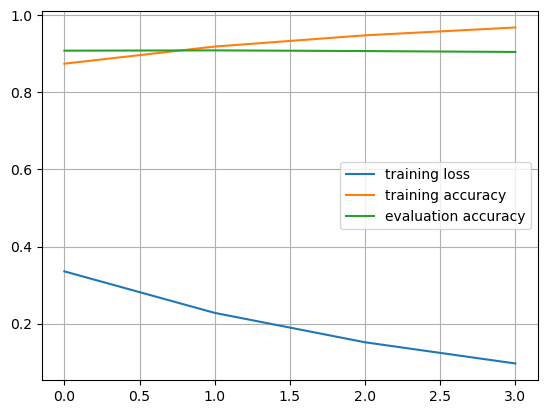

In [22]:
import matplotlib.pyplot as plt

# Data for plotting
t = np.arange(0.0, 100, 1)

# fig, ax = plt.subplots()
plt.plot(train_loss_list, label="training loss")
plt.plot(train_acc_list, label="training accuracy")
# plt.plot(eval_loss_list, label="evaluation loss")
plt.plot(eval_acc_list, label="evaluation accuracy")
plt.legend()
# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')
plt.grid()

# fig.savefig("test.png")
plt.show()